# Illustratrive Case Studies as a Proof of Concept of the Selection Method
Bramka Arga Jafino

Delft University of Technology

Faculty of Technology, Policy and Management

<a id='intro'></a>
## An introduction note

As a proof of concept of the selection method (please refer to Chapter 6 of the thesis report), two illustrative case studies are presented in this section. The case studies consist of two different hypothetical data availability and study purposes of Bangladesh’s freight transport network criticality analyses. There are three parts in each case study: (i) the problem background and selection of metrics set, (ii) results analysis, and (iii) visualization. 

#### Table of contents
- 1.1 <a href='#section_01'>Case study 1 introduction</a>
- 1.2 <a href='#section_02'>Case study 1 metrics comparison and elimination</a>
- 1.3 <a href='#section_03'>Case study 1 geovisualization</a>
- 2.1 <a href='#section_04'>Case study 2 introduction</a>
- 2.2 <a href='#section_05'>Case study 2 metrics comparison and elimination</a>
- 2.3 <a href='#section_06'>Case study 2 geovisualization</a>

## 0. Import all required module and files

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
import pandas as pd
from shapely.wkt import loads
import matplotlib.colors as colors
import seaborn as sns
from __future__ import division

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#Modules developed for this project
from transport_network_modeling import network_visualization as net_v
from transport_network_modeling import criticality as crit

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
import ipywidgets as widgets

In [2]:
#import criticality results
result_df_loc = r'./criticality_results/result_interdiction_1107noz2_v03.csv'
result_df = pd.read_csv(result_df_loc)

#import district shapefile for background
district_gdf_loc = r'./model_input_data/BGD_adm1.shp'
district_gdf = gp.read_file(district_gdf_loc)

In [3]:
#alter the 'geometry' string of the dataframe into geometry object
result_df['geometry'] = result_df['geometry'].apply(loads)

In [4]:
#alter the m5_01 criticality scores so that they are consistent to the formula  described in the report
result_df['m5_01'] = result_df.m5_01.apply(lambda x: 1/x if x > 0 else 2)

#remove one strange value in m2_02
result_df['m2_02'] = result_df.m2_02.apply(lambda val: 0 if val < 1.39e-10 else val)

In [5]:
#create geodataframe from criticality results dataframe
crs = {'init': 'epsg:4326'}
result_gdf = gp.GeoDataFrame(result_df, crs=crs, geometry=result_df['geometry'])

In [6]:
#record all metrics in a list
all_metric = ['m1_01', 'm1_02', 'm2_01', 'm2_02', 'm3_01', 'm3_02', 'm4_01', 'm4_02', 'm5_01', 'm6_01',
             'm7_01', 'm7_02', 'm7_03', 'm8_01', 'm8_02', 'm8_03', 'm9_01', 'm10']

#create ranking columns for each metric
for metric in all_metric:
    result_gdf[metric + '_rank'] = result_gdf[metric].rank(ascending=False)

<a id='section_01'></a>
## 1.1 Case study 1: Introduction

Bangladesh case. Situation: limited data (no useful socioeconomic data is available). The government is interested in finding out few most critical transport segments to prioritize precautionary budget for natural disaster preparedness.

Solution: no prespecified preference of functionality -> no socioeconomic data -> no specific time bound of the study -> metrics set A4_03. In order to deal with multiple criticality metrics outcomes, the raw data geovisualization technique is utilized.

Metrics set A4_03: [M1_01, M2_01, M3_01, M3_02, M4_01, M5_01] (please refer to Chapter 6 of the thesis report for more detail)

In [8]:
set_a403 = ['osmid', 'm1_01', 'm2_01', 'm3_01', 'm3_02', 'm4_01', 'm4_02', 'm5_01']
set_a403_noid = ['m1_01', 'm2_01', 'm3_01', 'm3_02', 'm4_01', 'm4_02', 'm5_01']

<a id='section_02'></a>
## 1.2 Case study 1: Metrics comparison and elimination

In [9]:
case1_result_gdf = result_gdf[set_a403]

Individual metric scores' distribution


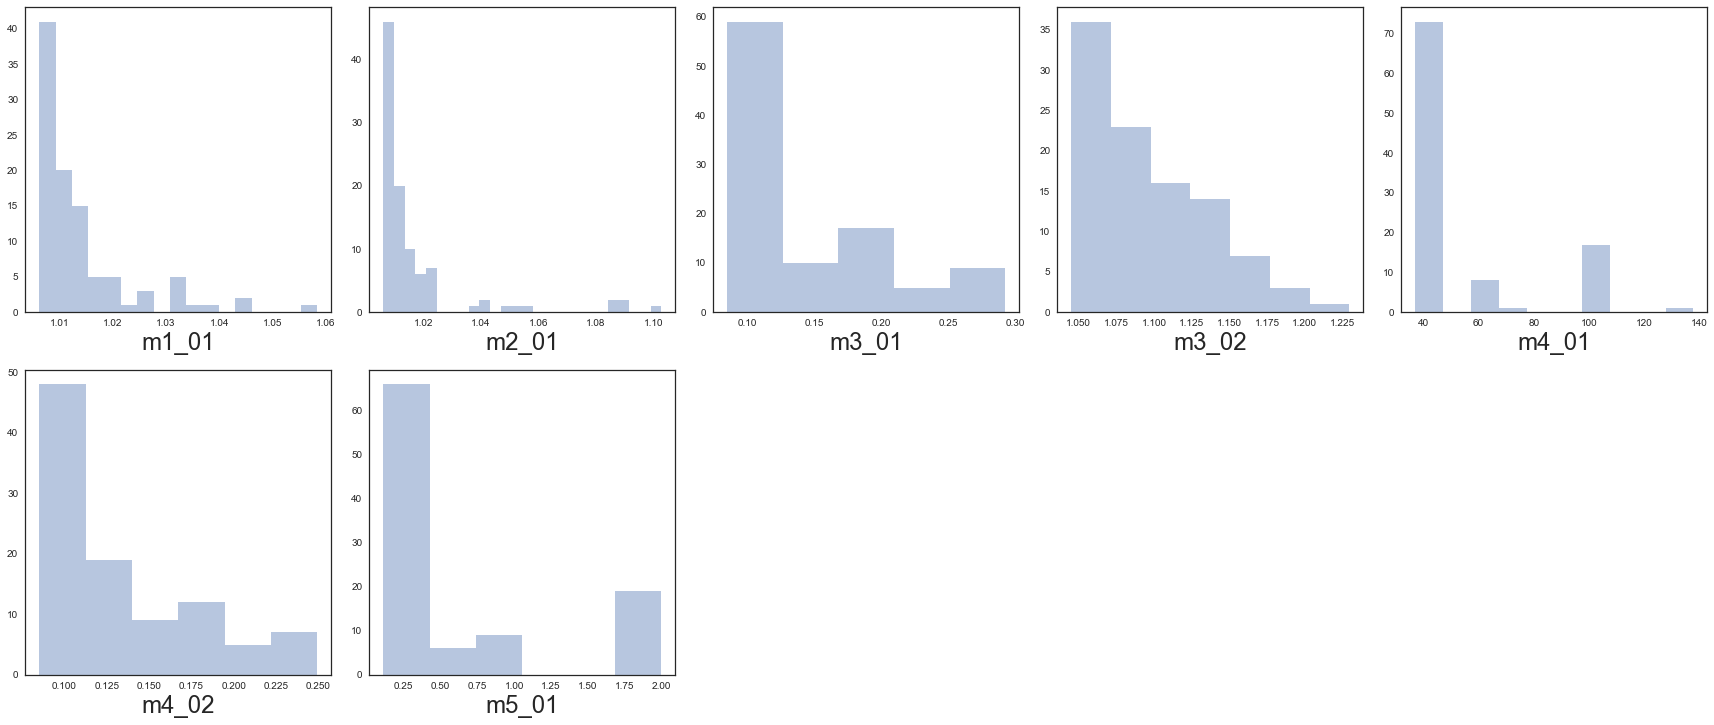

In [10]:
print("Individual metric scores' distribution")
fig1 = plt.figure(figsize=(24,60))
c=0
n=100
for num, metric in enumerate(set_a403_noid):
    new_df = case1_result_gdf[[metric, 'osmid']]
    new_df = new_df.loc[new_df[metric]!=0]
    topn_list = []
    try:
        topn_list.extend(list(new_df.sort_values(metric, ascending=False).osmid[:n]))
    except:
        topn_list.extend(list(new_df.sort_values(metric).osmid))
        
    new_df = new_df.loc[new_df['osmid'].isin(topn_list)]
    
    sns.set_style('white')
    exec("ax{} = fig1.add_subplot(12, 5, c+1)".format(num))
    exec("b = sns.distplot(new_df[metric], kde=False, rug=False, ax=ax{})".format(num))
    
    b.set_xlabel(metric, fontsize=24)
    c+=1
fig1.tight_layout()
plt.show()

Since the criticality scores are not normally distributed, Spearman rank correlation coefficient will be used

In [11]:
#First, create a DataFrame of union of top 100 critical links from all metrics
n=100
topn_list = []
for metric in set_a403_noid:
    new_data = case1_result_gdf.loc[case1_result_gdf[metric]!=0]
    try:
        topn_list.extend(list(new_data.sort_values(metric, ascending=False).osmid[:n]))
    except:
        topn_list.extend(list(new_data.sort_values(metric).osmid))
        
topn_list = list(set(topn_list))
data2 = case1_result_gdf.ix[:, case1_result_gdf.columns != 'osmid']
crit_df2 = case1_result_gdf.loc[case1_result_gdf['osmid'].isin(topn_list)]

#Then calculate the Spearman rank correlation coefficients between all metrics
spearmanr_df = pd.DataFrame(np.nan, index=data2.columns, columns=data2.columns)

for index, rows1 in spearmanr_df.iterrows():
    for value, rows2 in rows1.iteritems():
        r, p, n = crit.correlate_metrics_spearman(df=crit_df2, m_a=index, m_b=value)
        spearmanr_df.set_value(index, value, r)

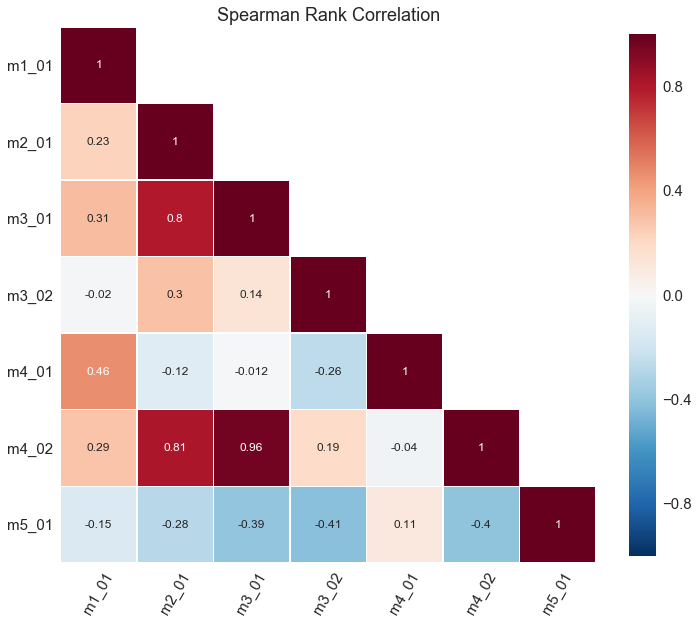

In [12]:
#Then, visualize it in a heatmap
net_v.correlation_plot(spearmanr_df, title='Spearman Rank Correlation')

Three metrics which are subject to be eliminated: m2_01, m3_01, m4_02.
But firstly we have to assess the KS distance

In [13]:
#First, create a DataFrame of union of top 100 critical links from all metrics
n=100
topn_list = []
for metric in set_a403_noid:
    new_data = case1_result_gdf.loc[case1_result_gdf[metric]!=0]
    try:
        topn_list.extend(list(new_data.sort_values(metric, ascending=False).osmid[:n]))
    except:
        topn_list.extend(list(new_data.sort_values(metric).osmid))
        
topn_list = list(set(topn_list))
data2 = case1_result_gdf.ix[:, case1_result_gdf.columns != 'osmid']
crit_df2 = case1_result_gdf.loc[case1_result_gdf['osmid'].isin(topn_list)]

#normalize between 0 and 1
#because the ks_2samp function assumes similar scale of values between the two datasets
for metric in set_a403_noid:
    minval = crit_df2[metric].min()
    maxval = crit_df2[metric].max()
    rang = maxval - minval
    crit_df2[metric] = crit_df2[metric].apply(lambda val: (val-minval)/rang)
    
#then calculate the KS distance
ks_df = pd.DataFrame(np.nan, index=data2.columns, columns=data2.columns)
for index, rows1 in ks_df.iterrows():
    for value, rows2 in rows1.iteritems():
        D, p = crit.correlate_metrics_ks(df=crit_df2, m_a=index, m_b=value)
        ks_df.set_value(index, value, D)

C:\Users\Lenovo\Anaconda2\lib\site-packages\ipykernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


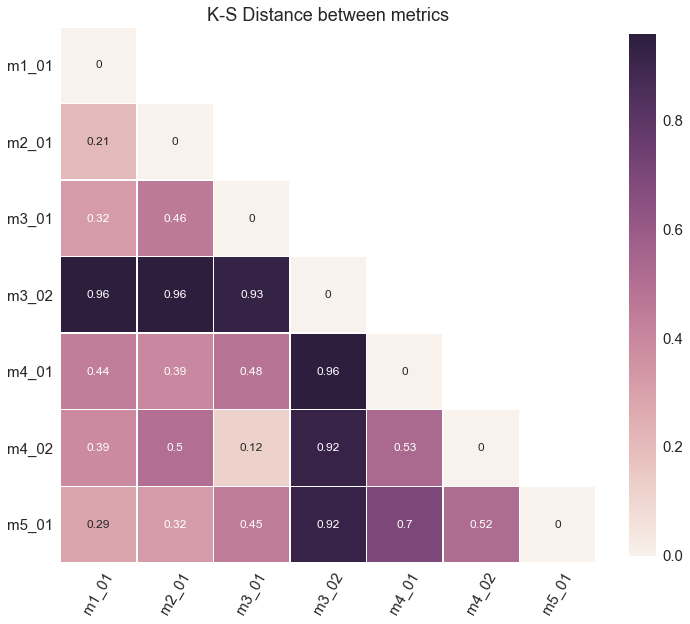

In [14]:
#Lastly, visualize it in a heatmap
net_v.correlation_plot(ks_df, title='K-S Distance between metrics')

We see that m3_02 has high KS distance with all other metrics. Therefore, m3_02 should not be eliminated. 
We choose to **eliminate m4_02** instead, as it has the highest average correlation coefficients with all other metrics.

<a id='section_03'></a>
## 1.3 Case study 1: Geovisualization

In [15]:
#extract the final criticality metrics set
set_final = ['FNODE_', 'TNODE_','geometry', 'mode','m1_01', 'm2_01', 'm3_01', 'm3_02', 'm4_01', 'm5_01']
set_final_metrics = ['m1_01', 'm2_01', 'm3_01', 'm3_02', 'm4_01', 'm5_01']
case1_final_gdf = result_gdf[set_final]

#create new ranking columns for each metric
n=100
case1_final_gdf['join'] = case1_final_gdf.apply(lambda row: str(row['FNODE_']) + str(row['TNODE_']), axis=1)
for num, metric in enumerate(set_final_metrics):
    case1_final_gdf2 = case1_final_gdf[[metric, 'join']]
    case1_final_gdf2 = case1_final_gdf2.loc[case1_final_gdf2[metric]!=0]
    topn_list = []
    topn_list.extend(list(case1_final_gdf2.sort_values(metric, ascending=False)['join'][:n]))
    case1_final_gdf[metric + '_top100'] = case1_final_gdf['join'].apply(lambda val: 1 if val in topn_list else 0)

C:\Users\Lenovo\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Lenovo\Anaconda2\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [18]:
#create special colormap for the visualization
cmap = plt.get_cmap('YlOrRd')
new_cmap1 = net_v.truncate_colormap(cmap, 0.3, 1)
cmap = plt.get_cmap('Blues')
new_cmap2 = net_v.truncate_colormap(cmap, 0.3, 1)

In [17]:
district_gdf['one'] = np.ones(len(district_gdf))

M1_01 top 100


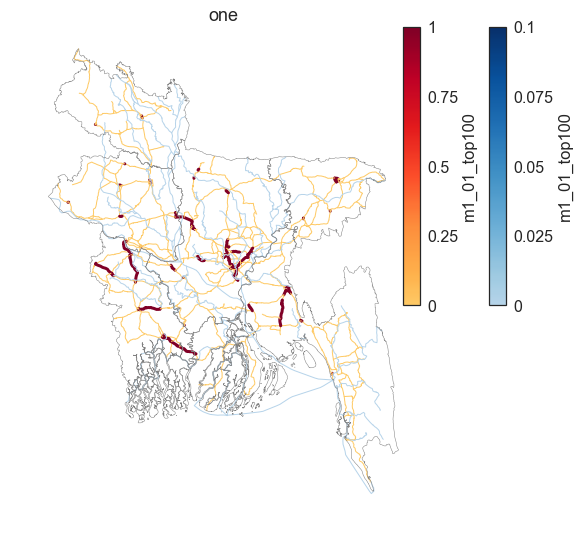

In [22]:
print('M1_01 top 100')
net_v.plot_network_multimodal(gdf=district_gdf, gdf2=case1_final_gdf, colname='one',
                        betweenness_string='m1_01_top100', 
                        cmaps=[new_cmap1, new_cmap2], maxvals=[0.1, 0.1],
                        perc1=60, perc2=90,
                        modes=['road', 'water'])

M2_01 top 100


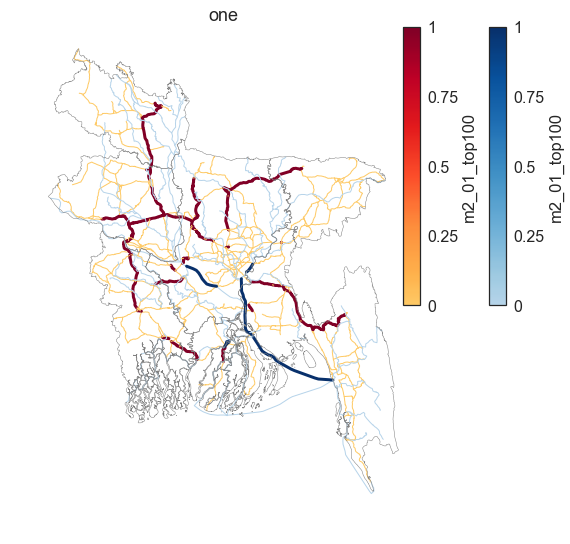

In [19]:
print('M2_01 top 100')
net_v.plot_network_multimodal(gdf=district_gdf, gdf2=case1_final_gdf, colname='one',
                        betweenness_string='m2_01_top100', 
                        cmaps=[new_cmap1, new_cmap2], maxvals=[0.1, 0.1],
                        perc1=60, perc2=90,
                        modes=['road', 'water'])

M3_01 top 100


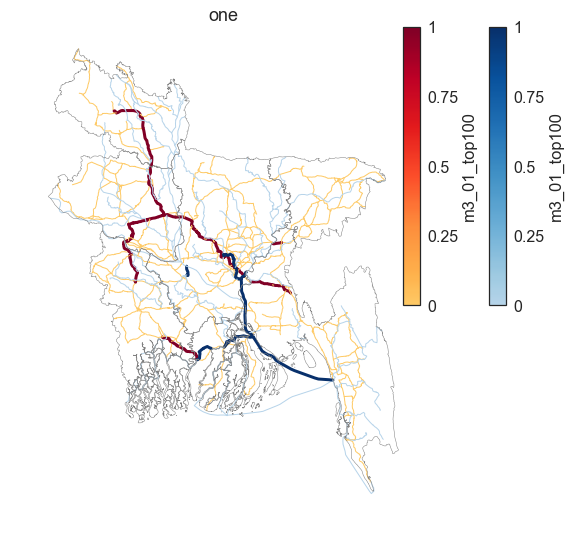

In [20]:
print('M3_01 top 100')
net_v.plot_network_multimodal(gdf=district_gdf, gdf2=case1_final_gdf, colname='one',
                        betweenness_string='m3_01_top100', 
                        cmaps=[new_cmap1, new_cmap2], maxvals=[0.1, 0.1],
                        perc1=60, perc2=90,
                        modes=['road', 'water'])

M3_02 top 100


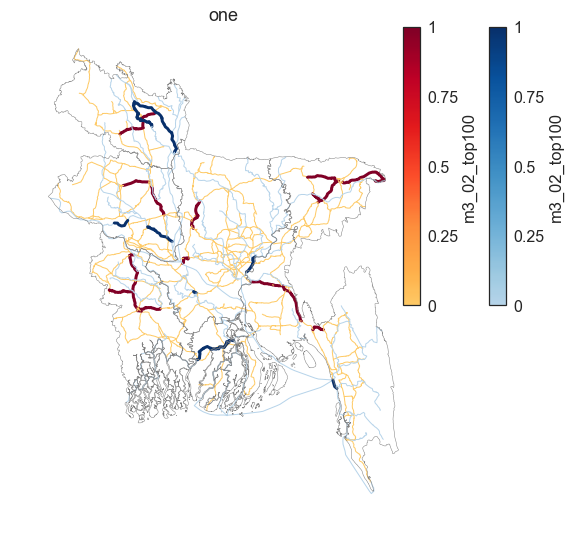

In [21]:
print('M3_02 top 100')
net_v.plot_network_multimodal(gdf=district_gdf, gdf2=case1_final_gdf, colname='one',
                        betweenness_string='m3_02_top100', 
                        cmaps=[new_cmap1, new_cmap2], maxvals=[0.1, 0.1],
                        perc1=60, perc2=90,
                        modes=['road', 'water'])

M4_01 top 100


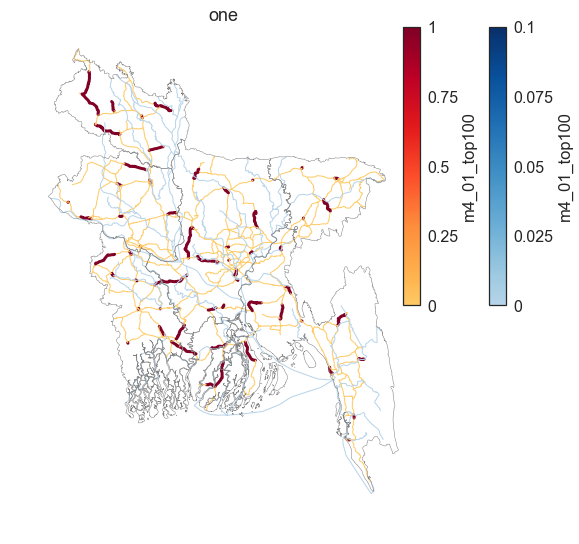

In [22]:
print('M4_01 top 100')
net_v.plot_network_multimodal(gdf=district_gdf, gdf2=case1_final_gdf, colname='one',
                        betweenness_string='m4_01_top100', 
                        cmaps=[new_cmap1, new_cmap2], maxvals=[0.1, 0.1],
                        perc1=60, perc2=90,
                        modes=['road', 'water'])

M5_01 top 100


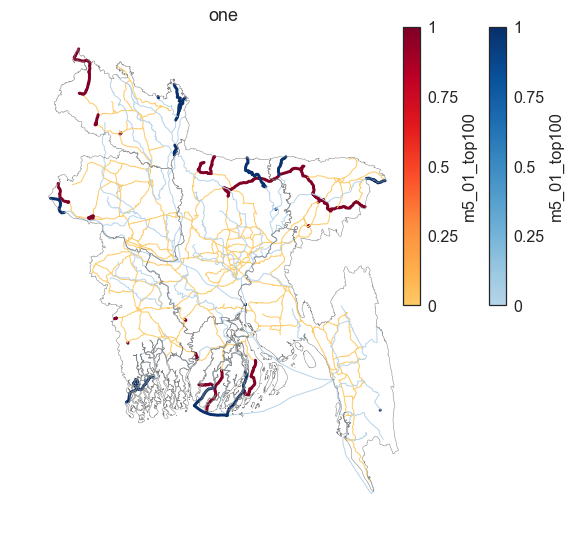

In [23]:
print('M5_01 top 100')
net_v.plot_network_multimodal(gdf=district_gdf, gdf2=case1_final_gdf, colname='one',
                        betweenness_string='m5_01_top100', 
                        cmaps=[new_cmap1, new_cmap2], maxvals=[0.1, 0.1],
                        perc1=60, perc2=90,
                        modes=['road', 'water'])

<a id='section_04'></a>
## 2.1 Case study 2: Introduction

Bangladesh case. Situation: the director of Road Transport and Highways Department (RHD) of Bangladesh and the director of Bangladesh’s Inland Waterway Transport Authority (BIWTA) call for a quick overview of the country’s multimodal (road + waterway) transport network criticality, in order to be presented in a brief meeting with the president.

Solution: no prespecified preference of functionality -> available socioeconomic data -> a relatively short time frame of the study, but sufficient enough computation power -> metrics set A3_02. In order to deal with multiple criticality metrics outcomes, a weighted average criticality score geovisualization will be developed.

Metrics set A3_02 = [M1_01 AND M3_01 AND M4_01 AND M5_01 AND M6_01 AND M8_01 AND M9_01 AND M10] (please refer to Chapter 6 of the thesis report for more detail)


In [7]:
set_a302 = ['osmid', 'm1_01', 'm3_01', 'm4_01', 'm5_01', 'm6_01', 'm8_01', 'm9_01', 'm10']
set_a302_noid = ['m1_01', 'm3_01', 'm4_01', 'm5_01', 'm6_01', 'm8_01', 'm9_01', 'm10']

<a id='section_05'></a>
## 2.2 Case study 2: Metrics comparison and elimination

In [8]:
case2_result_gdf = result_gdf[set_a302]

Individual metric scores' distribution


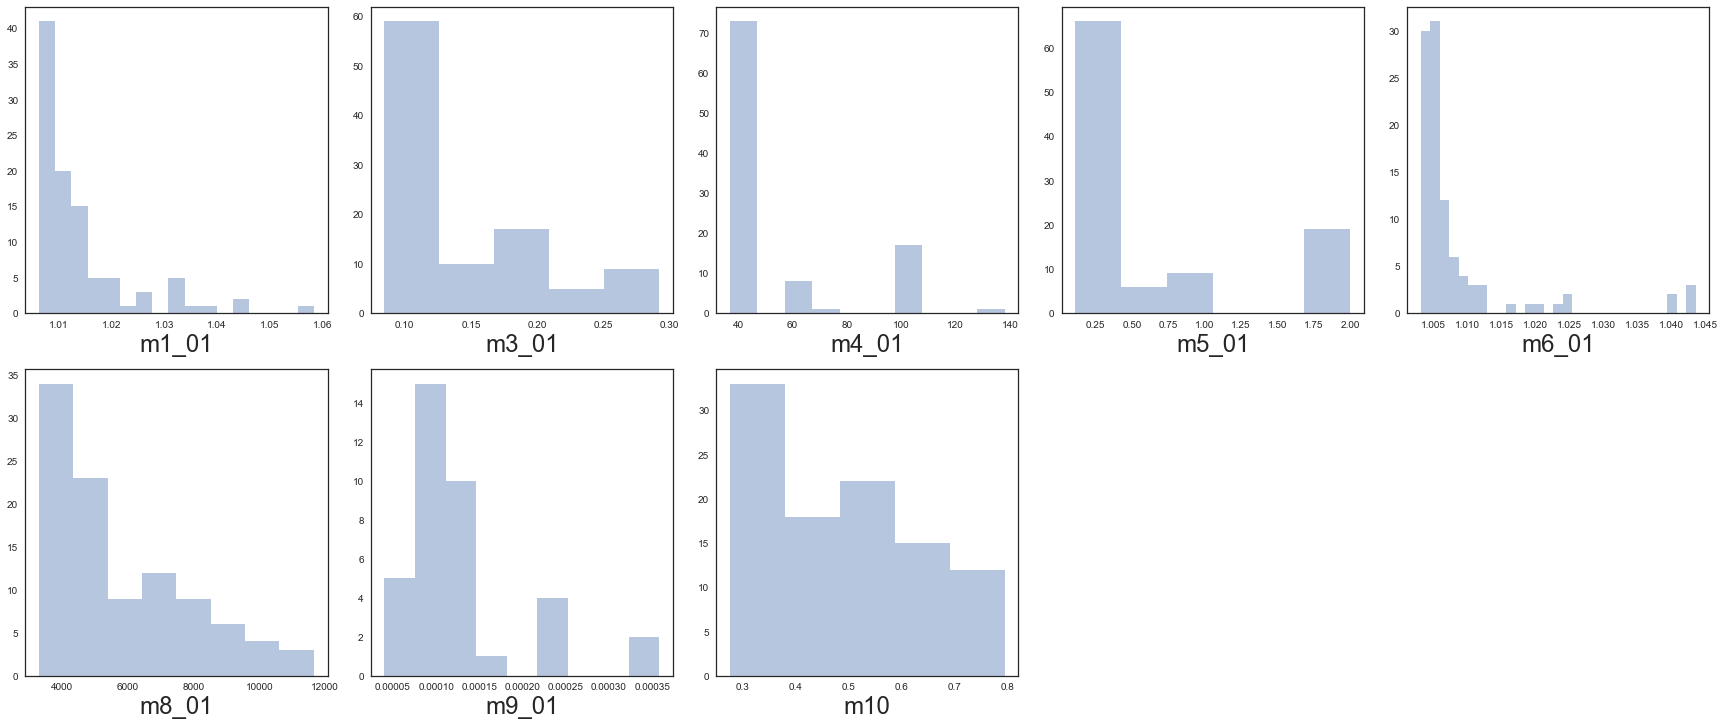

In [9]:
print("Individual metric scores' distribution")
fig1 = plt.figure(figsize=(24,60))
c=0
n=100
for num, metric in enumerate(set_a302_noid):
    new_df = case2_result_gdf[[metric, 'osmid']]
    new_df = new_df.loc[new_df[metric]!=0]
    topn_list = []
    try:
        topn_list.extend(list(new_df.sort_values(metric, ascending=False).osmid[:n]))
    except:
        topn_list.extend(list(new_df.sort_values(metric).osmid))
        
    new_df = new_df.loc[new_df['osmid'].isin(topn_list)]
    
    sns.set_style('white')
    exec("ax{} = fig1.add_subplot(12, 5, c+1)".format(num))
    exec("b = sns.distplot(new_df[metric], kde=False, rug=False, ax=ax{})".format(num))
    
    b.set_xlabel(metric, fontsize=24)
    c+=1
fig1.tight_layout()
plt.show()

Since the criticality scores are not normally distributed, Spearman rank correlation coefficient will be used

In [10]:
#First, create a DataFrame of union of top 100 critical links from all metrics
n=100
topn_list = []
for metric in set_a302_noid:
    new_data = case2_result_gdf.loc[case2_result_gdf[metric]!=0]
    try:
        topn_list.extend(list(new_data.sort_values(metric, ascending=False).osmid[:n]))
    except:
        topn_list.extend(list(new_data.sort_values(metric).osmid))
        
topn_list = list(set(topn_list))
data2 = case2_result_gdf.ix[:, case2_result_gdf.columns != 'osmid']
crit_df2 = case2_result_gdf.loc[case2_result_gdf['osmid'].isin(topn_list)]

#Then calculate the Spearman rank correlation coefficients between all metrics
spearmanr_df = pd.DataFrame(np.nan, index=data2.columns, columns=data2.columns)

for index, rows1 in spearmanr_df.iterrows():
    for value, rows2 in rows1.iteritems():
        r, p, n = crit.correlate_metrics_spearman(df=crit_df2, m_a=index, m_b=value)
        spearmanr_df.set_value(index, value, r)

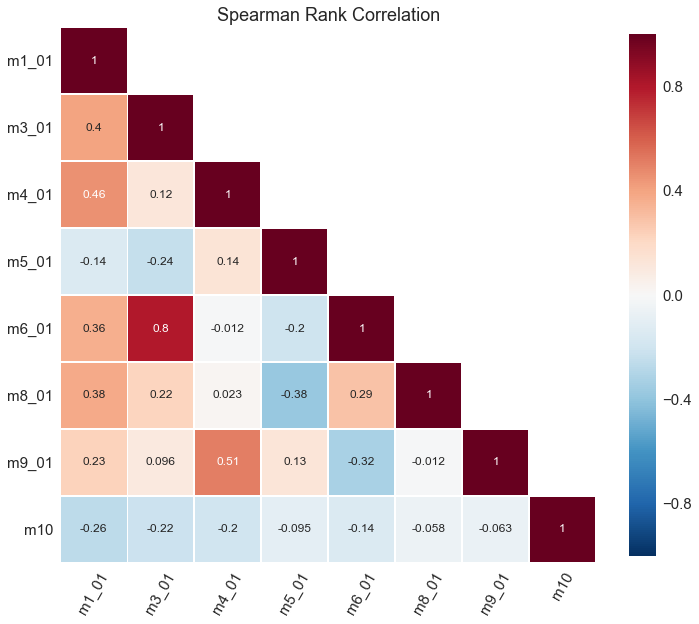

In [11]:
#Lastly, visualize it in a heatmap
net_v.correlation_plot(spearmanr_df, title='Spearman Rank Correlation')

Two metrics which are subject to be eliminated: m3_01, m6_01.
But firstly we have to assess the KS distance

In [12]:
#First, create a DataFrame of union of top 100 critical links from all metrics
n=100
topn_list = []
for metric in set_a302_noid:
    new_data = case2_result_gdf.loc[case2_result_gdf[metric]!=0]
    try:
        topn_list.extend(list(new_data.sort_values(metric, ascending=False).osmid[:n]))
    except:
        topn_list.extend(list(new_data.sort_values(metric).osmid))
        
topn_list = list(set(topn_list))
data2 = case2_result_gdf.ix[:, case2_result_gdf.columns != 'osmid']
crit_df2 = case2_result_gdf.loc[case2_result_gdf['osmid'].isin(topn_list)]

#normalize between 0 and 1
#because the ks_2samp function assumes similar scale of values between the two datasets
for metric in set_a302_noid:
    minval = crit_df2[metric].min()
    maxval = crit_df2[metric].max()
    rang = maxval - minval
    crit_df2[metric] = crit_df2[metric].apply(lambda val: (val-minval)/rang)
    
#then calculate the KS distance
ks_df = pd.DataFrame(np.nan, index=data2.columns, columns=data2.columns)
for index, rows1 in ks_df.iterrows():
    for value, rows2 in rows1.iteritems():
        D, p = crit.correlate_metrics_ks(df=crit_df2, m_a=index, m_b=value)
        ks_df.set_value(index, value, D)

C:\Users\Lenovo\Anaconda2\lib\site-packages\ipykernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


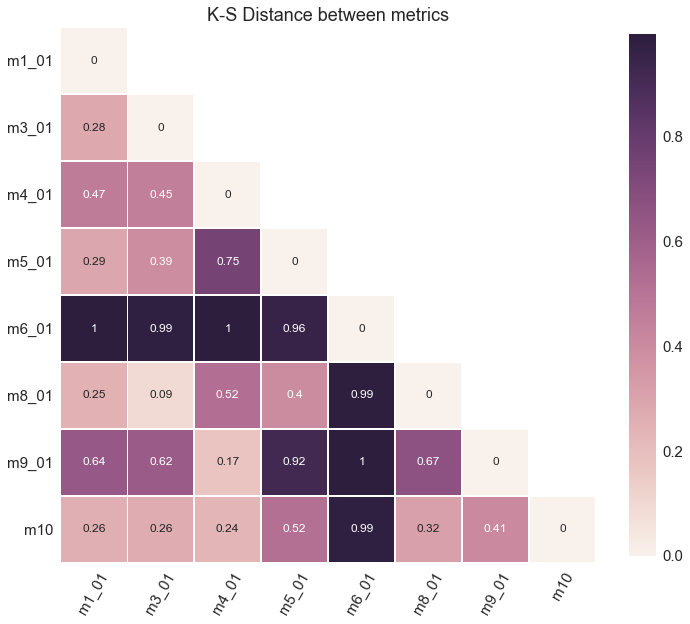

In [13]:
#Lastly, visualize it in a heatmap
net_v.correlation_plot(ks_df, title='K-S Distance between metrics')

We see that m6_01 has high KS distance with all other metrics. Therefore, m6_01 should not be eliminated. 
We choose to **eliminate m3_01** instead, as it also has the highest average correlation coefficients with all other metrics.

<a id='section_06'></a>
## 2.3 Case study 2 : Weighted average criticality value + geovisualization

In [14]:
#extract the final criticality metrics set
set_final = ['FNODE_', 'TNODE_','geometry', 'mode','m1_01', 'm4_01', 'm5_01', 'm6_01', 'm8_01', 'm9_01', 'm10']
set_a302_noid = ['m1_01', 'm4_01', 'm5_01', 'm6_01', 'm8_01', 'm9_01', 'm10']
case2_final_gdf = result_gdf[set_final]

In [15]:
#normalize between 0 and 1
#in accordance to the normalization requirement for calculating weighted average criticality value
#(see Section 6.2.5 in the thesis book)
for metric in set_a302_noid:
    minval = case2_final_gdf[metric].min()
    maxval = case2_final_gdf[metric].max()
    rang = maxval - minval
    case2_final_gdf[metric] = case2_final_gdf[metric].apply(lambda val: (val-minval)/rang)

C:\Users\Lenovo\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Since there is no mentioned preference of any of the criticality metrics, it is assumed that all metrics have the same preference. Thus, they are given the same weights.

In [16]:
case2_final_gdf['wa_crit'] = np.zeros(len(case2_final_gdf))
weight = 1/len(set_a302_noid)
for metric in set_a302_noid:
    case2_final_gdf['wa_crit'] += case2_final_gdf[metric] * weight
    
#record the rank based on the weighted average criticality score
case2_final_gdf['wa_crit_rank'] = case2_final_gdf['wa_crit'].rank(ascending=False)

C:\Users\Lenovo\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Lenovo\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Lenovo\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

100 top links are highlighted from metric wa_crit (Weighted average criticality score)


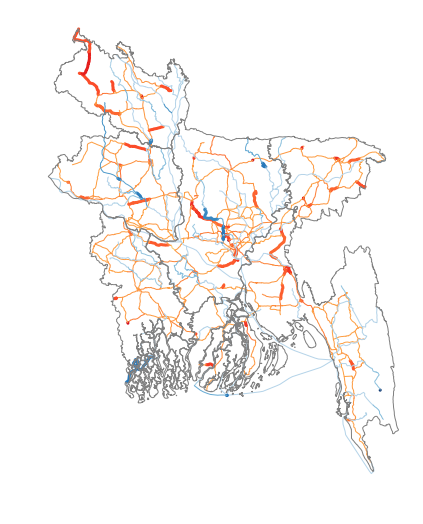

In [19]:
widgets.interact_manual(net_v.plot_interactive, rank=widgets.IntSlider(min=50, max=500, step=10, value=100),
                        show_division=widgets.Checkbox(value=False), result_gdf=fixed(case2_final_gdf),
                        cmaps=fixed([new_cmap1, new_cmap2]), district_gdf=fixed(district_gdf), metric=fixed('wa_crit'));

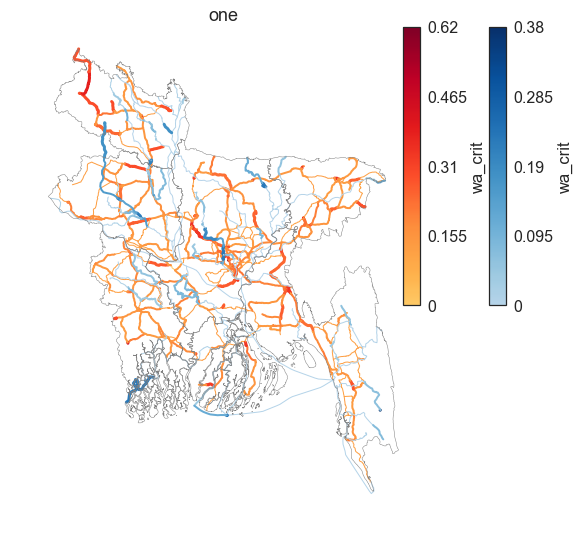

In [30]:
net_v.plot_network_multimodal(gdf=district_gdf, gdf2=case2_final_gdf, colname='one',
                        betweenness_string='wa_crit', 
                        cmaps=[new_cmap1, new_cmap2], maxvals=[0.62, 0.38], minvals=[0,0],
                        perc1=50, perc2=90,
                        modes=['road', 'water'])